In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print(">> using gpu")
else:  
    dev = "cpu"  
device = torch.device(dev) 

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def moving_average(array, window=3):
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)  # no padding so we lose 2 pixels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)  # no padding so we lose 2 pixels
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(in_features=64*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv1(x)  # input becomes 32x26x26
        x = F.relu(x)
        x = self.conv2(x)  # input becomes 64x24x24
        x = F.max_pool2d(x, kernel_size=2)  # input becomes 64x12x12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # flatten into a single 9,216 dim vector
        x = self.fc1(x)  # input goes from 9216 to 128
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # input goes from 128 to 10
        return x

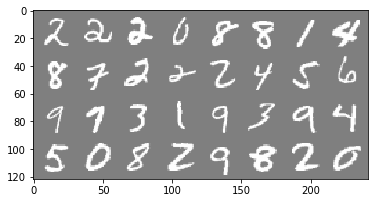

In [32]:
# labeled training data
batch = 32

dataset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
dataiter = iter(trainloader)

X_train, y_train = dataiter.next()

# gpu
X_train = X_train.to(device)
y_train = y_train.to(device)
imshow(torchvision.utils.make_grid(X_train))

In [46]:
# unlabeled training data
dataset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
dataiter = iter(trainloader)

# test data
dataset = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)
testdataiter = iter(testloader)

In [47]:
model = Net()
mode = model.to(device)  # pin the model on the proper device
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

accuracy = []

n_epochs = 200
threshold = .1

for epoch in range(n_epochs):
    
    # step 1: train on labeled data, which is never updated
    optimizer.zero_grad()
    output = model(X_train)
    real_loss = F.cross_entropy(output, y_train)
    
    # step 2: view probabilities on unlabeled data
    X_unlabeled, y_unlabeled = dataiter.next()  # representing weakly augmented and unlabeled data
    X_unlabeled = X_unlabeled.to(device)
    y_unlabeled = y_unlabeled.to(device)
    output = model(X_unlabeled)
    probs = F.softmax(output, dim=1)
    preds = probs.argmax(dim=1, keepdim=True)

    # step 3: train against pseudo labels only if it's high confidence
    fake_loss = 0
    counter = 0
    for a, pred, c in zip(probs, preds, X_unlabeled):
        if (a[pred] > threshold):
            counter += 1
            
            # step 4: generate strong augmentation data only if we'll use it
            X_strong = transforms.RandomErasing(p=1, ratio=(1, 1), scale=(0.01, 0.01), value=.1)(c).unsqueeze(0)

            # step 5: learn against pseudo labels
            output = model(X_strong)
            fake_loss += F.cross_entropy(output, pred)
    if counter > 0:
        fake_loss = fake_loss / counter  # take average fake loss
            
    total_loss = real_loss + fake_loss
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        dataiter = iter(trainloader)
        testdataiter = iter(testloader)
        
    # validate
    X_test, y_test = testdataiter.next()
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    correct = 0
    output = model(X_test)
    preds = output.argmax(dim=1, keepdim=True)
    correct += preds.eq(y_test.view_as(preds)).sum().item()
    accuracy.append(correct / len(y_test))
    if epoch % (n_epochs / 10) == 0:
        print("epoch:", epoch, "accuracy", correct / len(y_test))

epoch: 0 accuracy 0.0
epoch: 20 accuracy 0.15
epoch: 40 accuracy 0.15
epoch: 60 accuracy 0.05
epoch: 80 accuracy 0.05
epoch: 100 accuracy 0.05
epoch: 120 accuracy 0.05
epoch: 140 accuracy 0.2
epoch: 160 accuracy 0.15
epoch: 180 accuracy 0.3


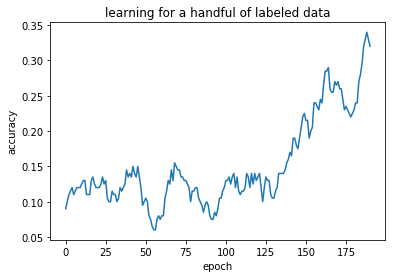

In [48]:
plt.title("learning for a handful of labeled data")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(moving_average(accuracy, window=10))

# step 1: establish baseline

In [49]:
baseline_model = Net()
baseline_optimizer = optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)
baseline_accuracy = []

for e in range(n_epochs):
    baseline_optimizer.zero_grad()
    output = baseline_model(X_train)
    loss = F.cross_entropy(output, y_train)
    loss.backward()
    baseline_optimizer.step()
    
    if e % 300 == 0:
        testdataiter = iter(testloader)
                
    # test
    X_test, y_test = testdataiter.next()
    correct = 0
    output = baseline_model(X_test)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(y_test.view_as(pred)).sum().item()
    baseline_accuracy.append(correct / len(y_test))
    if e % (n_epochs / 10) == 0:
        print("epoch:", e, "accuracy", correct / len(y_test))
    

epoch: 0 accuracy 0.25
epoch: 20 accuracy 0.1
epoch: 40 accuracy 0.15
epoch: 60 accuracy 0.2
epoch: 80 accuracy 0.2
epoch: 100 accuracy 0.15
epoch: 120 accuracy 0.45
epoch: 140 accuracy 0.55
epoch: 160 accuracy 0.65
epoch: 180 accuracy 0.45


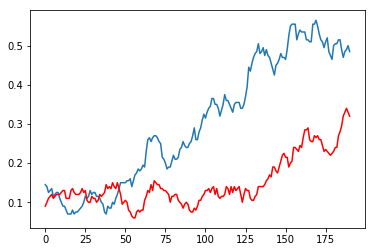

In [50]:
plt.plot(moving_average(baseline_accuracy, window=10))
plt.plot(moving_average(accuracy, window=10), c="r")